In [102]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import seaborn as sns
from netCDF4 import Dataset
import numpy.ma as ma
from statsmodels.stats.weightstats import DescrStatsW


In [154]:
import warnings
warnings.filterwarnings('ignore')

# Combine CEJST, EJScreen, and Census race-ethnicity data

In [155]:
# import isrm & census block crosswalk
isrm_fips_crosswalk = pd.read_csv("isrm_with_fips.csv",index_col = 0)

In [5]:
# import ejscreen data
# data can be downloaded from EJSCREEN
EJSCREEN_2020 = pd.read_csv("Justice40/EJSCREEN_2020_USPR.csv")["ID","MINORPCT","LOWINCPCT","PM25","P_MINORPCT","P_LWINCPCT","P_PM25"]]

In [10]:
isrm_fips_crosswalk["bg_ID"] = (isrm_fips_crosswalk["block_fip"]/1000).astype(int)

In [40]:
isrm_bg_crosswalk = isrm_fips_crosswalk.groupby(["isrm_grid_cell_num","bg_ID"]).agg({"population":"sum","centroid_latitude":"mean","centroid_longitude":"mean"}).reset_index()

In [41]:
isrm_bg_crosswalk = isrm_bg_crosswalk.rename(columns = {"isrm_grid_cell_num":"isrm","bg_ID":"ID"}).merge(EJSCREEN_2020,how = "left")

In [42]:
isrm_ejscreen = isrm_bg_crosswalk.groupby(["isrm"]).count().reset_index()[["isrm"]]
for i in isrm_bg_crosswalk.columns[5:13]:
    isrm_bg_crosswalk["test"] = isrm_bg_crosswalk[i]*isrm_bg_crosswalk["population"]
    g = isrm_bg_crosswalk.groupby(["isrm"])
    isrm_ejscreen[i]= (g["test"].sum()/g["population"].sum()).values

In [26]:
# import race-ethnicity data
isrm_pop_race_ethnicity = pd.read_csv("isrm_pop_race_ethnicity.csv",index_col = 0)

In [119]:
# merge ejscreen data with race-ethnicity data
isrm_multiyear_ejscreen = isrm_pop_race_ethnicity.merge(isrm_ejscreen)

In [120]:
# import justice40 race-ethnicity data
isrm_pop_race_ethnicity_J40_v1_land=pd.read_csv("isrm_pop_race_ethnicity_J40_v1_land.csv",index_col = 0)
isrm_pop_race_ethnicity_outside_v1_land=pd.read_csv("isrm_pop_race_ethnicity_outside_v1_land.csv",index_col = 0)

In [121]:
# merge three data sets
isrm_multiyear_ejscreen["J40_v1_land"] = np.where(isrm_multiyear_ejscreen.isrm.isin(isrm_pop_race_ethnicity_J40_v1_land.isrm.to_list()),"T","F")

In [122]:
isrm_multiyear_ejscreen["Other_Mixed"] = isrm_multiyear_ejscreen[["Other","Mixed"]].sum(axis = 1)

In [123]:
isrm_multiyear_ejscreen["Asian_Pacific"] = isrm_multiyear_ejscreen[["Hawaii","Asian"]].sum(axis = 1)

In [124]:
isrm_multiyear_ejscreen["Poverty"] = isrm_multiyear_ejscreen["Population"]*isrm_multiyear_ejscreen["LOWINCPCT"]
isrm_multiyear_ejscreen["Non-Poverty"] = isrm_multiyear_ejscreen["Population"]*(1-isrm_multiyear_ejscreen["LOWINCPCT"])
isrm_multiyear_ejscreen["POC"] = isrm_multiyear_ejscreen["Population"]-isrm_multiyear_ejscreen["White"]

In [218]:
isrm_multiyear_ejscreen.to_csv("isrm_multiyear_ejscreen.csv")

In [125]:
isrm_multiyear_ejscreen_J40 = isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["J40_v1_land"]=="T"]
isrm_multiyear_ejscreen_Outside = isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["J40_v1_land"]=="F"]

## Calculate demographic composition for Justice40 and non- Justice40 locations

In [64]:
race_composition_list_Total = []
for race in ["White","Hispanic","Black","Asian_Pacific","Native","Other_Mixed"]:
    race_composition_list_Total.append(isrm_multiyear_ejscreen[race].sum()/isrm_multiyear_ejscreen["Population"].sum()*100)
    
isrm_multiyear_ejscreen_J40 = isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["J40_v1_land"]=="T"]
isrm_multiyear_ejscreen_Outside = isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["J40_v1_land"]=="F"]

race_composition_list_J40 = []
for race in ["White","Hispanic","Black","Asian_Pacific","Native","Other_Mixed"]:
    race_composition_list_J40.append(isrm_multiyear_ejscreen_J40[race].sum()/isrm_multiyear_ejscreen_J40["Population"].sum()*100)

race_composition_list_Outside = []
for race in ["White","Hispanic","Black","Asian_Pacific","Native","Other_Mixed"]:
    race_composition_list_Outside.append(isrm_multiyear_ejscreen_Outside[race].sum()/isrm_multiyear_ejscreen_Outside["Population"].sum()*100)

    race_ethnic_composition_j40 = pd.DataFrame([race_composition_list_Total,race_composition_list_J40,race_composition_list_Outside],index=['Overall (whole US)',
                               'Justice40 communities',
                               'Other communities'],columns = ["White","Hispanic","Black","Asian","Native","Other/Mixed"])

In [66]:
race_composition_list_POC_Total = []
for race in ["Hispanic","Black","Asian_Pacific","Native","Other_Mixed"]:
    race_composition_list_POC_Total.append(isrm_multiyear_ejscreen[race].sum()/(isrm_multiyear_ejscreen["Population"].sum()-isrm_multiyear_ejscreen["White"].sum())*100)
    
isrm_multiyear_ejscreen_J40 = isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["J40_v1_land"]=="T"]
isrm_multiyear_ejscreen_Outside = isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["J40_v1_land"]=="F"]

race_composition_list_POC_J40 = []
for race in ["Hispanic","Black","Asian_Pacific","Native","Other_Mixed"]:
    race_composition_list_POC_J40.append(isrm_multiyear_ejscreen_J40[race].sum()/(isrm_multiyear_ejscreen_J40["Population"].sum()-isrm_multiyear_ejscreen_J40["White"].sum())*100)
race_composition_list_POC_Outside = []
for race in ["Hispanic","Black","Asian_Pacific","Native","Other_Mixed"]:
    race_composition_list_POC_Outside.append(isrm_multiyear_ejscreen_Outside[race].sum()/(isrm_multiyear_ejscreen_Outside["Population"].sum()-isrm_multiyear_ejscreen_Outside["White"].sum())*100)


race_ethnic_composition_POC_j40 = pd.DataFrame([race_composition_list_POC_Total,race_composition_list_POC_J40,race_composition_list_POC_Outside],index=['Overall (whole US)',
                               'Justice40 communities',
                               'Other communities'],columns = ["Hispanic","Black","Asian","Native","Other/Mixed"])#.reset_index()#.rename(columns = {"index":"Race"})

In [68]:
poverty_composition_list_Total = []
for poverty in ["Poverty","Non-Poverty"]:
    poverty_composition_list_Total.append(isrm_multiyear_ejscreen[poverty].sum()/isrm_multiyear_ejscreen["Population"].sum()*100)
isrm_multiyear_ejscreen_J40 = isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["J40_v1_land"]=="T"]
isrm_multiyear_ejscreen_Outside = isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["J40_v1_land"]=="F"]
    
poverty_composition_list_J40 = []
for poverty in ["Poverty","Non-Poverty"]:
    poverty_composition_list_J40.append(isrm_multiyear_ejscreen_J40[poverty].sum()/isrm_multiyear_ejscreen_J40["Population"].sum()*100)

    poverty_composition_list_Outside = []
for poverty in ["Poverty","Non-Poverty"]:
    poverty_composition_list_Outside.append(isrm_multiyear_ejscreen_Outside[poverty].sum()/isrm_multiyear_ejscreen_Outside["Population"].sum()*100)


poverty_ethnic_composition_j40 = pd.DataFrame([poverty_composition_list_Total,poverty_composition_list_J40,poverty_composition_list_Outside],index=['Overall (whole US)',
                               'Justice40 communities',
                               'Other communities'],columns = ["Low-income population","Other population"])#.reset_index()#.rename(columns = {"index":"poverty"})

In [70]:
J40_composition_list_Total = [isrm_multiyear_ejscreen_J40.Population.sum()/isrm_multiyear_ejscreen.Population.sum()*100,
                             isrm_multiyear_ejscreen_Outside.Population.sum()/isrm_multiyear_ejscreen.Population.sum()*100]
J40_composition_list_Poverty = [isrm_multiyear_ejscreen_J40.Poverty.sum()/isrm_multiyear_ejscreen.Poverty.sum()*100,
                             isrm_multiyear_ejscreen_Outside.Poverty.sum()/isrm_multiyear_ejscreen.Poverty.sum()*100]
J40_composition_list_NP = [isrm_multiyear_ejscreen_J40["Non-Poverty"].sum()/isrm_multiyear_ejscreen["Non-Poverty"].sum()*100,
                             isrm_multiyear_ejscreen_Outside["Non-Poverty"].sum()/isrm_multiyear_ejscreen["Non-Poverty"].sum()*100]

J40_poverty_composition = pd.DataFrame([J40_composition_list_Total,J40_composition_list_Poverty,J40_composition_list_NP],index=['Overall (whole US)',
                               'Low-income population',
                               'Other population'],columns = ["Justice40 communities","Other communities"])#.reset_index()#.rename(columns = {"index":"poverty"})


In [72]:
J40_composition_list_White = [isrm_multiyear_ejscreen_J40.White.sum()/isrm_multiyear_ejscreen.White.sum()*100,
                             isrm_multiyear_ejscreen_Outside.White.sum()/isrm_multiyear_ejscreen.White.sum()*100]
J40_composition_list_Hispanic = [isrm_multiyear_ejscreen_J40["Hispanic"].sum()/isrm_multiyear_ejscreen["Hispanic"].sum()*100,
                             isrm_multiyear_ejscreen_Outside["Hispanic"].sum()/isrm_multiyear_ejscreen["Hispanic"].sum()*100]
J40_composition_list_Black = [isrm_multiyear_ejscreen_J40["Black"].sum()/isrm_multiyear_ejscreen["Black"].sum()*100,
                             isrm_multiyear_ejscreen_Outside["Black"].sum()/isrm_multiyear_ejscreen["Black"].sum()*100]

J40_composition_list_Asian = [isrm_multiyear_ejscreen_J40["Asian_Pacific"].sum()/isrm_multiyear_ejscreen["Asian_Pacific"].sum()*100,
                             isrm_multiyear_ejscreen_Outside["Asian_Pacific"].sum()/isrm_multiyear_ejscreen["Asian_Pacific"].sum()*100]

J40_composition_list_Native = [isrm_multiyear_ejscreen_J40["Native"].sum()/isrm_multiyear_ejscreen["Native"].sum()*100,
                             isrm_multiyear_ejscreen_Outside["Native"].sum()/isrm_multiyear_ejscreen["Native"].sum()*100]

J40_composition_list_Other = [isrm_multiyear_ejscreen_J40["Other_Mixed"].sum()/isrm_multiyear_ejscreen["Other_Mixed"].sum()*100,
                             isrm_multiyear_ejscreen_Outside["Other_Mixed"].sum()/isrm_multiyear_ejscreen["Other_Mixed"].sum()*100]

J40_composition_list_POC = [isrm_multiyear_ejscreen_J40["POC"].sum()/isrm_multiyear_ejscreen["POC"].sum()*100,
                             isrm_multiyear_ejscreen_Outside["POC"].sum()/isrm_multiyear_ejscreen["POC"].sum()*100]

J40_race_composition = pd.DataFrame([J40_composition_list_Total,J40_composition_list_White,J40_composition_list_POC,
                                    J40_composition_list_Hispanic,J40_composition_list_Black,J40_composition_list_Asian,
                                    J40_composition_list_Native,J40_composition_list_Other],index=['Overall (whole US)',
                               'White','POC','Hispanic','Black','Asian','Native','Other/Mixed'],columns = ["Justice40 communities","Other communities"])#.reset_index()#.rename(columns = {"index":"poverty"})


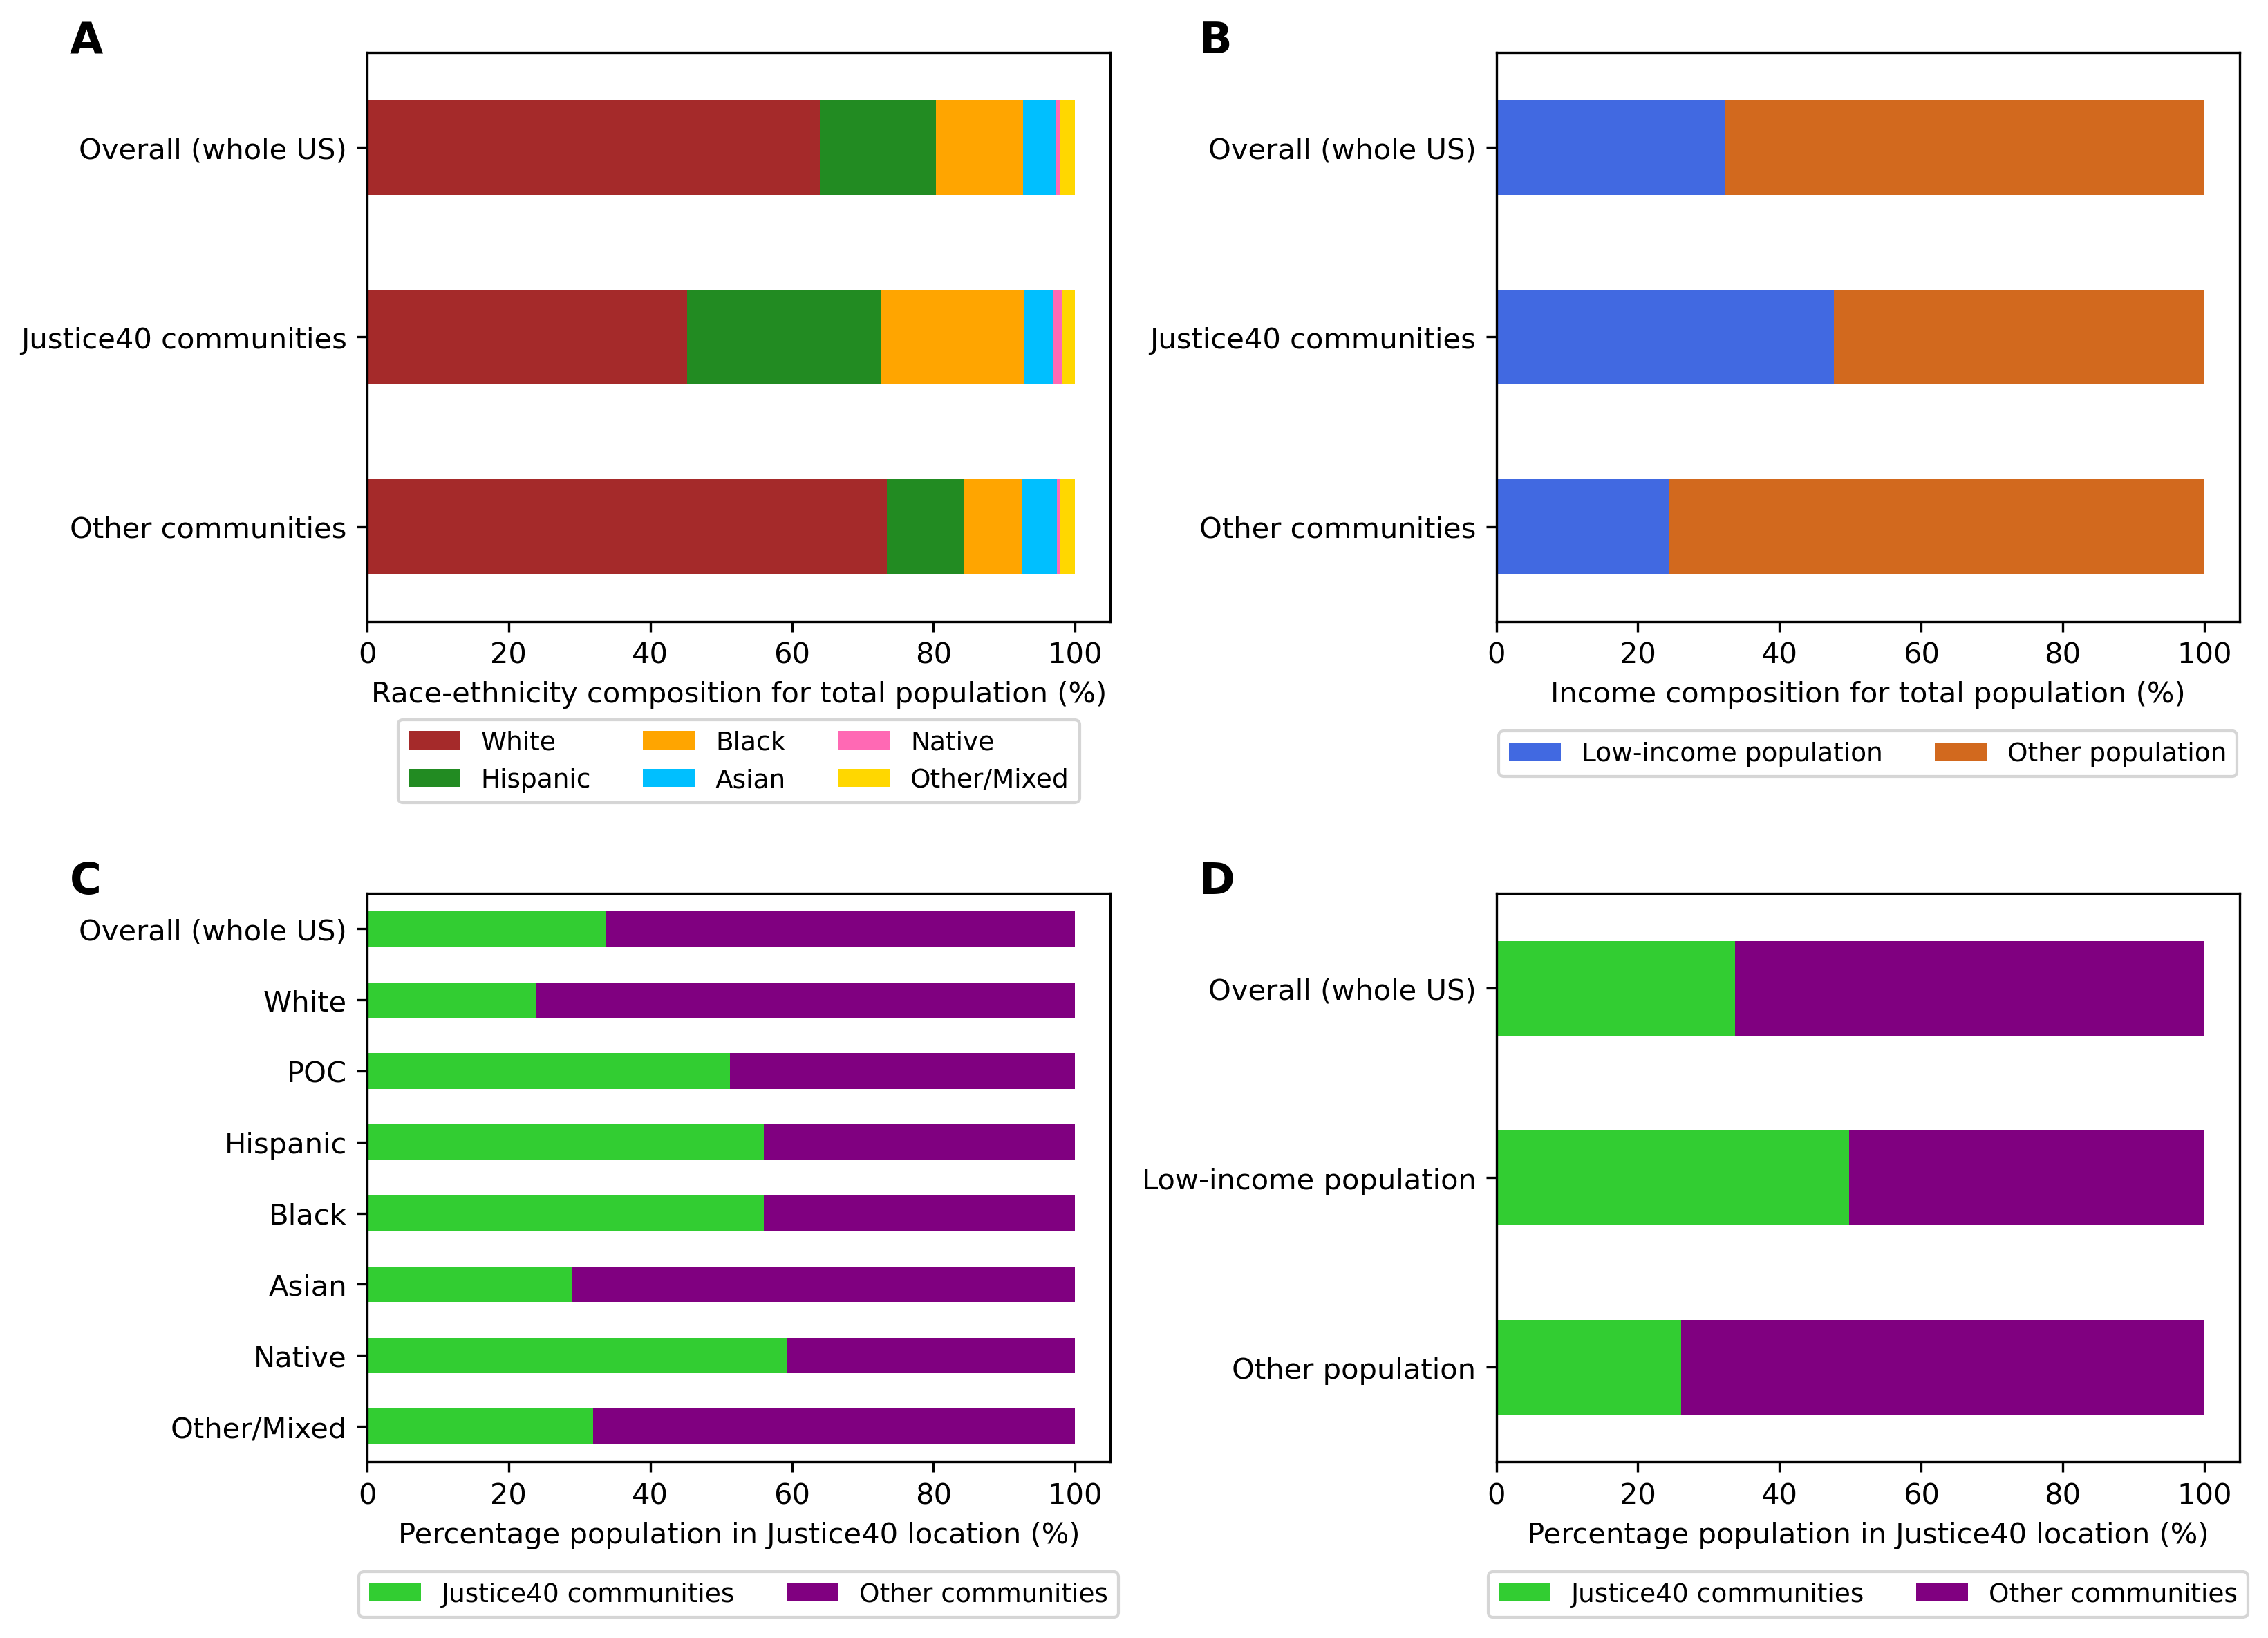

In [73]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = (11,8),dpi = 300)

race_ethnic_composition_j40[["White","Hispanic","Black","Asian","Native","Other/Mixed"]].plot(kind='barh', stacked=True, color=['brown','forestgreen', 'orange','deepskyblue','hotpink','gold'],ax = ax[0,0])
ax[0,0].set_xlabel('Race-ethnicity composition for total population (%)')
ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=False, ncol=3,prop = {"size":9})
ax[0,0].invert_yaxis()
ax[0,0].text(-0.4, 1., "A", transform=ax[0,0].transAxes, 
            size=15, weight='bold')


poverty_ethnic_composition_j40.plot(kind='barh', stacked=True, color=['royalblue', 'chocolate'],ax = ax[0,1])
ax[0,1].set_xlabel('Income composition for total population (%)')
ax[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
          fancybox=True, shadow=False, ncol=3,prop = {"size":9})
ax[0,1].invert_yaxis()
ax[0,1].text(-0.4, 1., "B", transform=ax[0,1].transAxes, 
            size=15, weight='bold')


J40_race_composition.plot(kind='barh', stacked=True, color=['limegreen', 'purple'],ax = ax[1,0])
ax[1,0].set_xlabel('Percentage population in Justice40 location (%)')
ax[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
          fancybox=True, shadow=False, ncol=3,prop = {"size":9})
ax[1,0].invert_yaxis()
ax[1,0].text(-0.4, 1., "C", transform=ax[1,0].transAxes, 
            size=15, weight='bold')

J40_poverty_composition.plot(kind='barh', stacked=True, color=['limegreen', 'purple'],ax = ax[1,1])
ax[1,1].set_xlabel('Percentage population in Justice40 location (%)')
ax[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
        fancybox=True, shadow=False, ncol=3,prop = {"size":9})
ax[1,1].invert_yaxis()
ax[1,1].text(-0.4, 1., "D", transform=ax[1,1].transAxes, 
            size=15, weight='bold')

plt.tight_layout(h_pad = 2)
plt.show()

# Calculate concentration changes based on emission reductions by sector

## Import 2014 nei emission data

In [74]:
nei_isrm_summary_state_new=pd.read_csv("nei_isrm_summary_state_new_scc.csv")

In [75]:
cmv_nei_isrm = gpd.read_file("2014_emissions/cmv.shp")

In [76]:
nei_isrm_summary_state_new = gpd.GeoDataFrame(nei_isrm_summary_state_new, geometry = [Point(x, y) for x, y in zip(nei_isrm_summary_state_new.x,nei_isrm_summary_state_new.y)], crs=cmv_nei_isrm.crs).drop(['x', 'y'], axis=1)

In [77]:
nei_isrm_summary_state_new.rename(columns={'PM25': 'PM2_5'}, inplace=True)

In [78]:
def set_height(row):
    if row["Height"] <= 57:
        return "ground"
    elif row["Height"] <= 379:
        return "low"
    else:
        return "high"

In [79]:
nei_isrm_summary_state_new = nei_isrm_summary_state_new.assign(height_type=nei_isrm_summary_state_new.apply(set_height, axis=1))

## Calculate concentration changes by sector only

In [82]:
sector_list = np.array(['Ag.', 'Coal Elec.', 'Const.', 'Cooking', 'Diesel HD Veh.',
       'Gas LD Veh.', 'Industrial', 'Misc.', 'Non-coal Elec.', 'Offroad',
       'Res. Gas', 'Res. Other', 'Res. Wood', 'Road Dst.'], dtype=object)


In [422]:
for num in range(14):
    for height in ["ground","low"]:
        vars()['sector_sum_'+str(num)+"_"+height] = nei_isrm_summary_state_new[(nei_isrm_summary_state_new["sector"] ==sector_list[num])&(nei_isrm_summary_state_new["height_type"] ==height)].reset_index(drop =True)

In [329]:
def sector_conc_value_j40(margin_data,emis_sum,pollutant):
    emis_sum_select = emis_sum[emis_sum[pollutant]>0].reset_index(drop = True)
    emis_isrm = emis_sum_select.isrm.to_list()
    emis_conc_total = emis_sum_select[pollutant].to_list()   
    temp1 = margin_data[emis_isrm,:]
    temp2 = temp1*(np.array([emis_conc_total]).T)
    isrm_conc_sum = temp2.sum(axis = 0)
    return(isrm_conc_sum) 

In [424]:
file = './PrimaryPM25L0.nc'
PM_isrm = Dataset(file, mode='r')

In [425]:
PM_isrm_data = ma.getdata(PM_isrm.variables["PrimaryPM25"][0])

In [330]:
for num in range(14):
    height = "ground"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        vars()['sector_'+str(num)+"_"+height+"_PM"] = sector_conc_value_j40(PM_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"PM2_5")

In [427]:
PM_isrm.close()

In [428]:
PM_isrm_data=0
gc.collect()

310

In [429]:
file = './PrimaryPM25L1.nc'
PM_isrm = Dataset(file, mode='r')

In [430]:
PM_isrm_data = ma.getdata(PM_isrm.variables["PrimaryPM25"][0])

In [335]:
for num in range(14):
    height = "low"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        vars()['sector_'+str(num)+"_"+height+"_PM"] = sector_conc_value_j40(PM_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"PM2_5")

In [432]:
PM_isrm.close()

In [433]:
PM_isrm_data=0
gc.collect()

111

In [434]:
file = './pNO3L0.nc'
NOx_isrm = Dataset(file, mode='r')

In [435]:
NOx_isrm_data = ma.getdata(NOx_isrm.variables["pNO3"][0])

In [340]:
for num in range(14):
    height = "ground"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        if vars()['sector_sum_'+str(num)+"_"+height]["NOx"].sum()>0:
            vars()['sector_'+str(num)+"_"+height+"_NOx"] = sector_conc_value_j40(NOx_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"NOx")

In [437]:
NOx_isrm.close()

In [438]:
NOx_isrm_data=0
gc.collect()

51

In [439]:
file = './pNO3L1.nc'
NOx_isrm = Dataset(file, mode='r')

In [440]:
NOx_isrm_data = ma.getdata(NOx_isrm.variables["pNO3"][0])

In [345]:
for num in range(14):
    height = "low"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        if vars()['sector_sum_'+str(num)+"_"+height]["NOx"].sum()>0:
            vars()['sector_'+str(num)+"_"+height+"_NOx"] = sector_conc_value_j40(NOx_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"NOx")

In [442]:
NOx_isrm.close()

In [443]:
NOx_isrm_data=0
gc.collect()

51

In [444]:
file = './pSO4L0.nc'
SOx_isrm = Dataset(file, mode='r')

In [445]:
SOx_isrm_data = ma.getdata(SOx_isrm.variables["pSO4"][0])

In [350]:
for num in range(14):
    height = "ground"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        if vars()['sector_sum_'+str(num)+"_"+height]["SOx"].sum()>0:
            vars()['sector_'+str(num)+"_"+height+"_SOx"] = sector_conc_value_j40(SOx_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"SOx")

In [447]:
SOx_isrm.close()

In [448]:
SOx_isrm_data=0
gc.collect()

51

In [449]:
file = './pSO4L1.nc'
SOx_isrm = Dataset(file, mode='r')

In [450]:
SOx_isrm_data = ma.getdata(SOx_isrm.variables["pSO4"][0])

In [355]:
for num in range(14):
    height = "low"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        if vars()['sector_sum_'+str(num)+"_"+height]["SOx"].sum()>0:
            vars()['sector_'+str(num)+"_"+height+"_SOx"] = sector_conc_value_j40(SOx_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"SOx")

In [452]:
SOx_isrm.close()

In [453]:
SOx_isrm_data=0
gc.collect()

51

In [454]:
file = './pNH4L0.nc'
NH3_isrm = Dataset(file, mode='r')

In [455]:
NH3_isrm_data = ma.getdata(NH3_isrm.variables["pNH4"][0])

In [360]:
for num in range(14):
    height = "ground"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        if vars()['sector_sum_'+str(num)+"_"+height]["NH3"].sum()>0:
            vars()['sector_'+str(num)+"_"+height+"_NH3"] = sector_conc_value_j40(NH3_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"NH3")

In [457]:
NH3_isrm.close()

In [458]:
NH3_isrm_data=0
gc.collect()

51

In [459]:
file = './pNH4L1.nc'
NH3_isrm = Dataset(file, mode='r')

In [460]:
NH3_isrm_data = ma.getdata(NH3_isrm.variables["pNH4"][0])

In [365]:
for num in range(14):
    height = "low"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        if vars()['sector_sum_'+str(num)+"_"+height]["NH3"].sum()>0:
            vars()['sector_'+str(num)+"_"+height+"_NH3"] = sector_conc_value_j40(NH3_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"NH3")

In [462]:
NH3_isrm.close()

In [463]:
NH3_isrm_data=0
gc.collect()

51

In [464]:
file = './SOAL0.nc'
VOC_isrm = Dataset(file, mode='r')

In [465]:
VOC_isrm_data = ma.getdata(VOC_isrm.variables["SOA"][0])

In [370]:
for num in range(14):
    height = "ground"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        if vars()['sector_sum_'+str(num)+"_"+height]["VOC"].sum()>0:
            vars()['sector_'+str(num)+"_"+height+"_VOC"] = sector_conc_value_j40(VOC_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"VOC")

In [467]:
VOC_isrm.close()

In [468]:
VOC_isrm_data=0
gc.collect()

51

In [469]:
file = './SOAL1.nc'
VOC_isrm = Dataset(file, mode='r')

In [470]:
VOC_isrm_data = ma.getdata(VOC_isrm.variables["SOA"][0])

In [375]:
for num in range(14):
    height = "low"
    if vars()['sector_sum_'+str(num)+"_"+height].shape[0]>0:
        if vars()['sector_sum_'+str(num)+"_"+height]["VOC"].sum()>0:
            vars()['sector_'+str(num)+"_"+height+"_VOC"] = sector_conc_value_j40(VOC_isrm_data,vars()['sector_sum_'+str(num)+"_"+height],"VOC")

In [472]:
VOC_isrm.close()

In [473]:
VOC_isrm_data=0
gc.collect()

51

In [107]:
pollutants = ["VOC","NOx","NH3","SOx","PM2_5"]

In [475]:
for sector_num in range(14):
    vars()['sector_'+str(sector_num)] = pd.DataFrame({"isrm":list(range(52411))})
    for pollutant in pollutants:
        if pollutant == "PM2_5":
            vars()['sector_'+str(sector_num)][pollutant] = 0
            for height in ["ground","low"]:
                try:
                    vars()['sector_'+str(sector_num)+"_"+height+"_PM"]
                except:
                    vars()['sector_'+str(sector_num)][pollutant] = vars()['sector_'+str(sector_num)][pollutant]
                else:
                    vars()['sector_'+str(sector_num)][pollutant] = vars()['sector_'+str(sector_num)][pollutant] + vars()['sector_'+str(sector_num)+"_"+height+"_PM"]
        else:
            vars()['sector_'+str(sector_num)][pollutant] = 0
            for height in ["ground","low"]:
                try:
                    vars()['sector_'+str(sector_num)+"_"+height+"_"+pollutant]
                except:
                    vars()['sector_'+str(sector_num)][pollutant] = vars()['sector_'+str(sector_num)][pollutant]
                else:
                    vars()['sector_'+str(sector_num)][pollutant] = vars()['sector_'+str(sector_num)][pollutant] + vars()['sector_'+str(sector_num)+"_"+height+"_"+pollutant]

In [476]:
for sector_num in range(14):
    vars()['sector_'+str(sector_num)].to_csv('sector_'+str(sector_num)+".csv")

In [507]:
sector_total = sector_0+sector_1+sector_2+sector_3+sector_4+sector_5+sector_6+sector_7+sector_8+sector_9+sector_10+sector_11+sector_12+sector_13

In [511]:
sector_total.isrm = range(52411)

In [510]:
sector_total["Total"] = sector_total[["VOC","NOx","NH3","SOx","PM2_5"]].sum(axis = 1)

In [513]:
sector_total.to_csv("Total_conc_by_pollutant.csv")

## Calculate concentration changes by sector & CEJST

In [111]:
nei_isrm_summary_state_new["J40_v1"] = np.where(
    nei_isrm_summary_state_new["isrm"].isin(isrm_pop_race_ethnicity_J40_v1_land.isrm.to_list()),"T","F")

In [112]:
sector_sum_v1 = nei_isrm_summary_state_new.groupby(["sector","J40_v1"]).agg({"VOC":"sum","NOx":"sum","NH3":"sum","SOx":"sum","PM2_5":"sum"}).reset_index()

In [675]:
for num in range(14):
    for height in ["ground","low"]:
        for J40 in["T","F"]:
            vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40] = nei_isrm_summary_state_new[(nei_isrm_summary_state_new["sector"] ==sector_list[num])&(nei_isrm_summary_state_new["height_type"] ==height)&(nei_isrm_summary_state_new["J40_v1"]==J40)].reset_index(drop =True)

In [670]:
file = './PrimaryPM25L0.nc'
PM_isrm = Dataset(file, mode='r')

In [671]:
PM_isrm_data = ma.getdata(PM_isrm.variables["PrimaryPM25"][0])

In [676]:
for num in range(14):
    height = "ground"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_PM"] = sector_conc_value_j40(PM_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"PM2_5")

In [677]:
PM_isrm.close()

In [678]:
PM_isrm_data=0
gc.collect()

40

In [679]:
file = './PrimaryPM25L1.nc'
PM_isrm = Dataset(file, mode='r')

In [680]:
PM_isrm_data = ma.getdata(PM_isrm.variables["PrimaryPM25"][0])

In [681]:
for num in range(14):
    height = "low"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_PM"] = sector_conc_value_j40(PM_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"PM2_5")

In [682]:
PM_isrm.close()

In [683]:
PM_isrm_data=0
gc.collect()

51

In [684]:
file = './pNO3L0.nc'
NOx_isrm = Dataset(file, mode='r')

In [685]:
NOx_isrm_data = ma.getdata(NOx_isrm.variables["pNO3"][0])

In [686]:
for num in range(14):
    height = "ground"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40]["NOx"].sum()>0:
                vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_NOx"] = sector_conc_value_j40(NOx_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"NOx")

In [687]:
NOx_isrm.close()

In [688]:
NOx_isrm_data=0
gc.collect()

51

In [689]:
file = './pNO3L1.nc'
NOx_isrm = Dataset(file, mode='r')

In [690]:
NOx_isrm_data = ma.getdata(NOx_isrm.variables["pNO3"][0])

In [691]:
for num in range(14):
    height = "low"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40]["NOx"].sum()>0:
                vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_NOx"] = sector_conc_value_j40(NOx_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"NOx")

In [692]:
NOx_isrm.close()

In [693]:
NOx_isrm_data=0
gc.collect()

51

In [694]:
file = './pSO4L0.nc'
SOx_isrm = Dataset(file, mode='r')

In [695]:
SOx_isrm_data = ma.getdata(SOx_isrm.variables["pSO4"][0])

In [696]:
for num in range(14):
    height = "ground"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40]["SOx"].sum()>0:
                vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_SOx"] = sector_conc_value_j40(SOx_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"SOx")

In [697]:
SOx_isrm.close()

In [698]:
SOx_isrm_data=0
gc.collect()

51

In [699]:
file = './pSO4L1.nc'
SOx_isrm = Dataset(file, mode='r')

In [700]:
SOx_isrm_data = ma.getdata(SOx_isrm.variables["pSO4"][0])

In [701]:
for num in range(14):
    height = "low"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40]["SOx"].sum()>0:
                vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_SOx"] = sector_conc_value_j40(SOx_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"SOx")

In [702]:
SOx_isrm.close()

In [703]:
SOx_isrm_data=0
gc.collect()

51

In [704]:
file = './pNH4L0.nc'
NH3_isrm = Dataset(file, mode='r')

In [705]:
NH3_isrm_data = ma.getdata(NH3_isrm.variables["pNH4"][0])

In [706]:
for num in range(14):
    height = "ground"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40]["NH3"].sum()>0:
                vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_NH3"] = sector_conc_value_j40(NH3_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"NH3")

In [707]:
NH3_isrm.close()

In [708]:
NH3_isrm_data=0
gc.collect()

51

In [709]:
file = './pNH4L1.nc'
NH3_isrm = Dataset(file, mode='r')

In [710]:
NH3_isrm_data = ma.getdata(NH3_isrm.variables["pNH4"][0])

In [711]:
for num in range(14):
    height = "low"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40]["NH3"].sum()>0:
                vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_NH3"] = sector_conc_value_j40(NH3_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"NH3")

In [712]:
NH3_isrm.close()

In [713]:
NH3_isrm_data=0
gc.collect()

51

In [714]:
file = './SOAL0.nc'
VOC_isrm = Dataset(file, mode='r')

In [715]:
VOC_isrm_data = ma.getdata(VOC_isrm.variables["SOA"][0])

In [716]:
for num in range(14):
    height = "ground"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40]["VOC"].sum()>0:
                vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_VOC"] = sector_conc_value_j40(VOC_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"VOC")

In [717]:
VOC_isrm.close()

In [718]:
VOC_isrm_data=0
gc.collect()

51

In [719]:
file = './SOAL1.nc'
VOC_isrm = Dataset(file, mode='r')

In [720]:
VOC_isrm_data = ma.getdata(VOC_isrm.variables["SOA"][0])

In [721]:
for num in range(14):
    height = "low"
    for J40 in["T","F"]:
        if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40].shape[0]>0:
            if vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40]["VOC"].sum()>0:
                vars()['sector_v1_'+str(num)+"_"+height+"_"+J40+"_VOC"] = sector_conc_value_j40(VOC_isrm_data,vars()['sector_sum_v1_'+str(num)+"_"+height+"_"+J40],"VOC")

In [722]:
VOC_isrm.close()

In [723]:
VOC_isrm_data=0
gc.collect()

51

In [725]:
for sector_num in range(14):
    for J40 in["T","F"]:
        vars()['sector_v1_'+str(sector_num)+"_"+J40] = pd.DataFrame({"isrm":list(range(52411))})
        for pollutant in pollutants:
            if pollutant == "PM2_5":
                vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant] = 0
                for height in ["ground","low"]:
                    try:
                        vars()['sector_v1_'+str(sector_num)+"_"+height+"_"+J40+"_PM"]
                    except:
                        vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant] = vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant]
                    else:
                        vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant] = vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant] + vars()['sector_v1_'+str(sector_num)+"_"+height+"_"+J40+"_PM"]
            else:
                vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant] = 0
                for height in ["ground","low"]:
                    try:
                        vars()['sector_v1_'+str(sector_num)+"_"+height+"_"+J40+"_"+pollutant]
                    except:
                        vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant] = vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant]
                    else:
                        vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant] = vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant] + vars()['sector_v1_'+str(sector_num)+"_"+height+"_"+J40+"_"+pollutant]

In [726]:
for sector_num in range(14):
    for J40 in["T","F"]:
        vars()['sector_v1_'+str(sector_num)+"_"+J40].to_csv('sector_v1_'+str(sector_num)+"_"+J40+".csv")

## Calculate concentration changes by sector & EJScreen

In [144]:
nei_isrm_summary_state_new["LWINC_30"] = np.where(
    nei_isrm_summary_state_new["isrm"].isin(isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["LOWINCPCT"]>
                                                                   DescrStatsW(data=np.array(isrm_multiyear_ejscreen["LOWINCPCT"]), 
                                                                               weights=isrm_multiyear_ejscreen["Population"]).quantile(probs=0.7,return_pandas=False)[0]].isrm.to_list()),"T","F")

In [145]:
nei_isrm_summary_state_new["MINOR_30"] = np.where(
    nei_isrm_summary_state_new["isrm"].isin(isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["MINORPCT"]>
                                                                   DescrStatsW(data=np.array(isrm_multiyear_ejscreen["MINORPCT"]), 
                                                                               weights=isrm_multiyear_ejscreen["Population"]).quantile(probs=0.7,return_pandas=False)[0]].isrm.to_list()),"T","F")

In [146]:
nei_isrm_summary_state_new["PM25_30"] = np.where(
    nei_isrm_summary_state_new["isrm"].isin(isrm_multiyear_ejscreen[isrm_multiyear_ejscreen["PM25"]>
                                                                   DescrStatsW(data=np.array(isrm_multiyear_ejscreen["PM25"]), 
                                                                               weights=isrm_multiyear_ejscreen["Population"]).quantile(probs=0.7,return_pandas=False)[0]].isrm.to_list()),"T","F")

In [142]:
LEZ_index = ["LWINC_30","MINOR_30","PM25_30"]

In [777]:
for ej_variable in LEZ_index:
    vars()['sector_sum_'+ej_variable] = nei_isrm_summary_state_new.groupby(["sector",ej_variable]).agg({"VOC":"sum","NOx":"sum","NH3":"sum","SOx":"sum","PM2_5":"sum"}).reset_index()
    vars()['sector_sum_'+ej_variable].to_csv('sector_sum_'+ej_variable+".csv")

In [779]:
for num in range(14):
    for height in ["ground","low"]:
        for ej_variable in LEZ_index:
            for J40 in["T","F"]:
                vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40] = nei_isrm_summary_state_new[(nei_isrm_summary_state_new["sector"] ==sector_list[num])&(nei_isrm_summary_state_new["height_type"] ==height)&(nei_isrm_summary_state_new[ej_variable]==J40)].reset_index(drop =True)

In [781]:
file = './PrimaryPM25L0.nc'
PM_isrm = Dataset(file, mode='r')

In [782]:
PM_isrm_data = ma.getdata(PM_isrm.variables["PrimaryPM25"][0])

In [784]:
for num in range(14):
    height = "ground"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_PM"] = sector_conc_value_j40(PM_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"PM2_5")

In [786]:
PM_isrm.close()

In [787]:
PM_isrm_data=0
gc.collect()

87

In [788]:
file = './PrimaryPM25L1.nc'
PM_isrm = Dataset(file, mode='r')

In [789]:
PM_isrm_data = ma.getdata(PM_isrm.variables["PrimaryPM25"][0])

In [790]:
for num in range(14):
    height = "low"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["PM2_5"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_PM"] = sector_conc_value_j40(PM_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"PM2_5")

In [791]:
PM_isrm.close()

In [792]:
PM_isrm_data=0
gc.collect()

51

In [793]:
file = './pNO3L0.nc'
NOx_isrm = Dataset(file, mode='r')

In [794]:
NOx_isrm_data = ma.getdata(NOx_isrm.variables["pNO3"][0])

In [795]:
for num in range(14):
    height = "ground"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["NOx"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_NOx"] = sector_conc_value_j40(NOx_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"NOx")


In [796]:
NOx_isrm.close()

In [797]:
NOx_isrm_data=0
gc.collect()

51

In [798]:
file = './pNO3L1.nc'
NOx_isrm = Dataset(file, mode='r')

In [799]:
NOx_isrm_data = ma.getdata(NOx_isrm.variables["pNO3"][0])

In [800]:
for num in range(14):
    height = "low"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["NOx"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_NOx"] = sector_conc_value_j40(NOx_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"NOx")


In [801]:
NOx_isrm.close()

In [802]:
NOx_isrm_data=0
gc.collect()

51

In [803]:
file = './pSO4L0.nc'
SOx_isrm = Dataset(file, mode='r')

In [804]:
SOx_isrm_data = ma.getdata(SOx_isrm.variables["pSO4"][0])

In [805]:
for num in range(14):
    height = "ground"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["SOx"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_SOx"] = sector_conc_value_j40(SOx_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"SOx")


In [806]:
SOx_isrm.close()

In [807]:
SOx_isrm_data=0
gc.collect()

51

In [808]:
file = './pSO4L1.nc'
SOx_isrm = Dataset(file, mode='r')

In [809]:
SOx_isrm_data = ma.getdata(SOx_isrm.variables["pSO4"][0])

In [810]:
for num in range(14):
    height = "low"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["SOx"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_SOx"] = sector_conc_value_j40(SOx_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"SOx")


In [811]:
SOx_isrm.close()

In [812]:
SOx_isrm_data=0
gc.collect()

51

In [813]:
file = './pNH4L0.nc'
NH3_isrm = Dataset(file, mode='r')

In [814]:
NH3_isrm_data = ma.getdata(NH3_isrm.variables["pNH4"][0])

In [815]:
for num in range(14):
    height = "ground"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["NH3"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_NH3"] = sector_conc_value_j40(NH3_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"NH3")


In [816]:
NH3_isrm.close()

In [817]:
NH3_isrm_data=0
gc.collect()

51

In [818]:
file = './pNH4L1.nc'
NH3_isrm = Dataset(file, mode='r')

In [819]:
NH3_isrm_data = ma.getdata(NH3_isrm.variables["pNH4"][0])

In [820]:
for num in range(14):
    height = "low"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["NH3"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_NH3"] = sector_conc_value_j40(NH3_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"NH3")


In [821]:
NH3_isrm.close()

In [822]:
NH3_isrm_data=0
gc.collect()

51

In [823]:
file = './SOAL0.nc'
VOC_isrm = Dataset(file, mode='r')

In [824]:
VOC_isrm_data = ma.getdata(VOC_isrm.variables["SOA"][0])

In [825]:
for num in range(14):
    height = "ground"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["VOC"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_VOC"] = sector_conc_value_j40(VOC_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"VOC")


In [826]:
VOC_isrm.close()

In [827]:
VOC_isrm_data=0
gc.collect()

51

In [828]:
file = './SOAL1.nc'
VOC_isrm = Dataset(file, mode='r')

In [829]:
VOC_isrm_data = ma.getdata(VOC_isrm.variables["SOA"][0])

In [830]:
for num in range(14):
    height = "low"
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40].shape[0]>0:
                if vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40]["VOC"].sum()>0:
                    vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40+"_VOC"] = sector_conc_value_j40(VOC_isrm_data,vars()['sector_sum_'+str(num)+"_"+height+"_"+ej_variable+"_"+J40],"VOC")


In [831]:
VOC_isrm.close()

In [832]:
VOC_isrm_data=0
gc.collect()

51

In [834]:
for sector_num in range(14):
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40] = pd.DataFrame({"isrm":list(range(52411))})
            for pollutant in pollutants:
                if pollutant == "PM2_5":
                    vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant] = 0
                    for height in ["ground","low"]:
                        try:
                            vars()['sector_sum_'+str(sector_num)+"_"+height+"_"+ej_variable+"_"+J40+"_PM"]
                        except:
                            vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant]  = vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant]
                        else:
                            vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant]  = vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant] + vars()['sector_sum_'+str(sector_num)+"_"+height+"_"+ej_variable+"_"+J40+"_PM"]
                else:
                    vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant] = 0
                    for height in ["ground","low"]:
                        try:
                            vars()['sector_sum_'+str(sector_num)+"_"+height+"_"+ej_variable+"_"+J40+"_"+pollutant]
                        except:
                            vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant] = vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant]
                        else:
                            vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant] = vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant] + vars()['sector_sum_'+str(sector_num)+"_"+height+"_"+ej_variable+"_"+J40+"_"+pollutant]

In [835]:
for sector_num in range(14):
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40].to_csv('./LEZ_conc_margin/sector_'+str(sector_num)+"_"+ej_variable+"_"+J40+".csv")

# Calculate concentration changes for demographic groups

In [135]:
sector_sum = nei_isrm_summary_state_new.groupby(["sector",]).agg({"VOC":"sum","NOx":"sum","NH3":"sum","SOx":"sum","PM2_5":"sum"}).reset_index()
sector_emis_reduce_list=[]
pollutant_list=[]
sector_name_list=[]
sector_emis_list = []

conc_p = []

conc_j40_v1_land=[]
conc_outside_v1_land = []

conc_w=[]
conc_b = []
conc_a = []
conc_h = []
conc_m = []
conc_n = []
conc_o = []
conc_lowinc = []
conc_highinc = []

for sector_num in range(14):
    for pollutant in pollutants:
        if sector_sum[pollutant][sector_num]>0:
            sector_emis = sector_sum[pollutant][sector_num]/31709.79
            sector_conc = vars()['sector_'+str(sector_num)][pollutant]
            sector_conc_total = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Population"].values)/isrm_multiyear_ejscreen["Population"].sum()

            sector_conc_j40_v1_land = sum(sector_conc[isrm_pop_race_ethnicity_J40_v1_land.isrm.to_list()]*isrm_pop_race_ethnicity_J40_v1_land["Population"].values)/isrm_pop_race_ethnicity_J40_v1_land["Population"].sum()
            sector_conc_outside_v1_land = sum(sector_conc[isrm_pop_race_ethnicity_outside_v1_land.isrm.to_list()]*isrm_pop_race_ethnicity_outside_v1_land["Population"].values)/isrm_pop_race_ethnicity_outside_v1_land["Population"].sum()

            sector_conc_w = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["White"].values)/isrm_multiyear_ejscreen["White"].sum()
            sector_conc_b = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Black"].values)/isrm_multiyear_ejscreen["Black"].sum()
            sector_conc_a = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Asian_Pacific"].values)/isrm_multiyear_ejscreen["Asian_Pacific"].sum()
            sector_conc_h = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Hispanic"].values)/isrm_multiyear_ejscreen["Hispanic"].sum()
            sector_conc_m = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Mixed"].values)/isrm_multiyear_ejscreen["Mixed"].sum()
            sector_conc_n = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Native"].values)/isrm_multiyear_ejscreen["Native"].sum()
            sector_conc_o = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Other"].values)/isrm_multiyear_ejscreen["Other"].sum()
            sector_conc_lowinc = np.nansum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()].values*isrm_multiyear_ejscreen["Population"]*isrm_multiyear_ejscreen["LOWINCPCT"])/np.nansum(isrm_multiyear_ejscreen["Population"]*isrm_multiyear_ejscreen["LOWINCPCT"])
            sector_conc_highinc = np.nansum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()].values*isrm_multiyear_ejscreen["Population"]*(1-isrm_multiyear_ejscreen["LOWINCPCT"]))/np.nansum(isrm_multiyear_ejscreen["Population"]*(1-isrm_multiyear_ejscreen["LOWINCPCT"]))

            sector_emis_list.append(sector_emis)
            conc_p.append(sector_conc_total)

            conc_j40_v1_land.append(sector_conc_j40_v1_land)
            conc_outside_v1_land.append(sector_conc_outside_v1_land)
            
            conc_w.append(sector_conc_w)
            conc_b.append(sector_conc_b)
            conc_a.append(sector_conc_a)
            conc_h.append(sector_conc_h)
            conc_m.append(sector_conc_m)
            conc_n.append(sector_conc_n)
            conc_o.append(sector_conc_o)            
            conc_lowinc.append(sector_conc_lowinc)            
            conc_highinc.append(sector_conc_highinc)            

            pollutant_list.append(pollutant)
            sector_name_list.append(sector_list[sector_num])

sector_pollutant_justice40_ejscreen_race = pd.DataFrame.from_dict({'emis':sector_emis_list,
"conc_p":conc_p,"pollutant":pollutant_list,
"sector":sector_name_list,"conc_j40_v1_land":conc_j40_v1_land,"conc_outside_v1_land":conc_outside_v1_land,
                          "conc_w":conc_w,"conc_b":conc_b,"conc_a":conc_a,
                          "conc_h":conc_h,"conc_m":conc_m,"conc_n":conc_n,
                          "conc_o":conc_o,"conc_lowinc":conc_lowinc,"conc_highinc":conc_highinc})

In [138]:
sector_pollutant_justice40_ejscreen_race.to_csv("sector_pollutant_justice40_ejscreen_race_new.csv")

In [139]:
sector_sum_v1_J40 = nei_isrm_summary_state_new.groupby(["sector","J40_v1"]).agg({"VOC":"sum","NOx":"sum","NH3":"sum","SOx":"sum","PM2_5":"sum"}).reset_index()
sector_emis_reduce_list=[]
pollutant_list=[]
sector_name_list=[]
sector_emis_list = []
J40_list = []

conc_p = []
conc_j40_v1_land=[]
conc_outside_v1_land = []

conc_w=[]
conc_b = []
conc_a = []
conc_h = []
conc_m = []
conc_n = []
conc_o = []
conc_lowinc = []
conc_highinc = []

for sector_num in range(14):
    for J40 in["T","F"]:
        sector_sum_v1_select = sector_sum_v1_J40[sector_sum_v1_J40["J40_v1"]==J40].reset_index(drop = True)
        for pollutant in pollutants:
            if sector_sum_v1_select[pollutant][sector_num]>0:
                sector_emis = sector_sum_v1_select[pollutant][sector_num]/31709.79
                sector_conc = vars()['sector_v1_'+str(sector_num)+"_"+J40][pollutant]
                sector_conc_total = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Population"].values)/isrm_multiyear_ejscreen["Population"].sum()
                sector_conc_j40_v1_land = sum(sector_conc[isrm_pop_race_ethnicity_J40_v1_land.isrm.to_list()]*isrm_pop_race_ethnicity_J40_v1_land["Population"].values)/isrm_pop_race_ethnicity_J40_v1_land["Population"].sum()
                sector_conc_outside_v1_land = sum(sector_conc[isrm_pop_race_ethnicity_outside_v1_land.isrm.to_list()]*isrm_pop_race_ethnicity_outside_v1_land["Population"].values)/isrm_pop_race_ethnicity_outside_v1_land["Population"].sum()
                sector_conc_w = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["White"].values)/isrm_multiyear_ejscreen["White"].sum()
                sector_conc_b = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Black"].values)/isrm_multiyear_ejscreen["Black"].sum()
                sector_conc_a = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Asian_Pacific"].values)/isrm_multiyear_ejscreen["Asian_Pacific"].sum()
                sector_conc_h = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Hispanic"].values)/isrm_multiyear_ejscreen["Hispanic"].sum()
                sector_conc_m = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Mixed"].values)/isrm_multiyear_ejscreen["Mixed"].sum()
                sector_conc_n = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Native"].values)/isrm_multiyear_ejscreen["Native"].sum()
                sector_conc_o = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Other"].values)/isrm_multiyear_ejscreen["Other"].sum()
                sector_conc_lowinc = np.nansum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()].values*isrm_multiyear_ejscreen["Population"]*isrm_multiyear_ejscreen["LOWINCPCT"])/np.nansum(isrm_multiyear_ejscreen["Population"]*isrm_multiyear_ejscreen["LOWINCPCT"])
                sector_conc_highinc = np.nansum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()].values*isrm_multiyear_ejscreen["Population"]*(1-isrm_multiyear_ejscreen["LOWINCPCT"]))/np.nansum(isrm_multiyear_ejscreen["Population"]*(1-isrm_multiyear_ejscreen["LOWINCPCT"]))

                sector_emis_list.append(sector_emis)
                conc_p.append(sector_conc_total)

                conc_j40_v1_land.append(sector_conc_j40_v1_land)
                conc_outside_v1_land.append(sector_conc_outside_v1_land)

                conc_w.append(sector_conc_w)
                conc_b.append(sector_conc_b)
                conc_a.append(sector_conc_a)
                conc_h.append(sector_conc_h)
                conc_m.append(sector_conc_m)
                conc_n.append(sector_conc_n)
                conc_o.append(sector_conc_o)            
                conc_lowinc.append(sector_conc_lowinc)            
                conc_highinc.append(sector_conc_highinc)            

                pollutant_list.append(pollutant)
                J40_list.append(J40)
                sector_name_list.append(sector_list[sector_num])

sector_pollutant_justice40_v1_ejscreen_race_LEZ = pd.DataFrame.from_dict({'emis':sector_emis_list,
"conc_p":conc_p,"pollutant":pollutant_list,"J40_v1":J40_list,
"sector":sector_name_list,"conc_j40_v1_land":conc_j40_v1_land,"conc_outside_v1_land":conc_outside_v1_land,
                          "conc_w":conc_w,"conc_b":conc_b,"conc_a":conc_a,
                          "conc_h":conc_h,"conc_m":conc_m,"conc_n":conc_n,
                          "conc_o":conc_o,"conc_lowinc":conc_lowinc,"conc_highinc":conc_highinc})

In [140]:
sector_pollutant_justice40_v1_ejscreen_race_LEZ.to_csv("sector_pollutant_justice40_v1_ejscreen_race_LEZ_new.csv")

In [148]:
for sector_num in range(14):
    for ej_variable in LEZ_index:
        for J40 in["T","F"]:
            vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40]=pd.read_csv('./LEZ_conc_margin/sector_'+str(sector_num)+"_"+ej_variable+"_"+J40+".csv",index_col = 0)

In [149]:
for ej_variable in LEZ_index:
    sector_sum_J40 = nei_isrm_summary_state_new.groupby(["sector",ej_variable]).agg({"VOC":"sum","NOx":"sum","NH3":"sum","SOx":"sum","PM2_5":"sum"}).reset_index()
    sector_emis_reduce_list=[]
    pollutant_list=[]
    sector_name_list=[]
    sector_emis_list = []
    J40_list = []

    conc_p = []
    conc_j40_v1_land=[]
    conc_outside_v1_land = []

    conc_w=[]
    conc_b = []
    conc_a = []
    conc_h = []
    conc_m = []
    conc_n = []
    conc_o = []
    conc_lowinc = []
    conc_highinc = []

    for sector_num in range(14):
        for J40 in["T","F"]:
            sector_sum_select = sector_sum_J40[sector_sum_J40[ej_variable]==J40].reset_index(drop = True)
            for pollutant in pollutants:
                if sector_sum_select[pollutant][sector_num]>0:
                    sector_emis = sector_sum_select[pollutant][sector_num]/31709.79
                    sector_conc = vars()['sector_'+str(sector_num)+"_"+ej_variable+"_"+J40][pollutant]
                    sector_conc_total = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Population"].values)/isrm_multiyear_ejscreen["Population"].sum()
                    sector_conc_j40_v1_land = sum(sector_conc[isrm_pop_race_ethnicity_J40_v1_land.isrm.to_list()]*isrm_pop_race_ethnicity_J40_v1_land["Population"].values)/isrm_pop_race_ethnicity_J40_v1_land["Population"].sum()
                    sector_conc_outside_v1_land = sum(sector_conc[isrm_pop_race_ethnicity_outside_v1_land.isrm.to_list()]*isrm_pop_race_ethnicity_outside_v1_land["Population"].values)/isrm_pop_race_ethnicity_outside_v1_land["Population"].sum()

                    sector_conc_w = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["White"].values)/isrm_multiyear_ejscreen["White"].sum()
                    sector_conc_b = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Black"].values)/isrm_multiyear_ejscreen["Black"].sum()
                    sector_conc_a = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Asian_Pacific"].values)/isrm_multiyear_ejscreen["Asian_Pacific"].sum()
                    sector_conc_h = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Hispanic"].values)/isrm_multiyear_ejscreen["Hispanic"].sum()
                    sector_conc_m = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Mixed"].values)/isrm_multiyear_ejscreen["Mixed"].sum()
                    sector_conc_n = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Native"].values)/isrm_multiyear_ejscreen["Native"].sum()
                    sector_conc_o = sum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()]*isrm_multiyear_ejscreen["Other"].values)/isrm_multiyear_ejscreen["Other"].sum()
                    sector_conc_lowinc = np.nansum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()].values*isrm_multiyear_ejscreen["Population"]*isrm_multiyear_ejscreen["LOWINCPCT"])/np.nansum(isrm_multiyear_ejscreen["Population"]*isrm_multiyear_ejscreen["LOWINCPCT"])
                    sector_conc_highinc = np.nansum(sector_conc[isrm_multiyear_ejscreen.isrm.to_list()].values*isrm_multiyear_ejscreen["Population"]*(1-isrm_multiyear_ejscreen["LOWINCPCT"]))/np.nansum(isrm_multiyear_ejscreen["Population"]*(1-isrm_multiyear_ejscreen["LOWINCPCT"]))

                    sector_emis_list.append(sector_emis)
                    conc_p.append(sector_conc_total)

                    conc_j40_v1_land.append(sector_conc_j40_v1_land)
                    conc_outside_v1_land.append(sector_conc_outside_v1_land)

                    conc_w.append(sector_conc_w)
                    conc_b.append(sector_conc_b)
                    conc_a.append(sector_conc_a)
                    conc_h.append(sector_conc_h)
                    conc_m.append(sector_conc_m)
                    conc_n.append(sector_conc_n)
                    conc_o.append(sector_conc_o)            
                    conc_lowinc.append(sector_conc_lowinc)            
                    conc_highinc.append(sector_conc_highinc)            

                    pollutant_list.append(pollutant)
                    J40_list.append(J40)
                    sector_name_list.append(sector_list[sector_num])

    vars()["sector_pollutant_justice40_ejscreen_race_LEZ_"+ej_variable] = pd.DataFrame.from_dict({'emis':sector_emis_list,
    "conc_p":conc_p,"pollutant":pollutant_list,ej_variable:J40_list,
    "sector":sector_name_list,"conc_j40_v1_land":conc_j40_v1_land,"conc_outside_v1_land":conc_outside_v1_land,
                                                        "conc_w":conc_w,"conc_b":conc_b,"conc_a":conc_a,
                                                             "conc_h":conc_h,"conc_m":conc_m,"conc_n":conc_n,
                                                             "conc_o":conc_o,"conc_lowinc":conc_lowinc,"conc_highinc":conc_highinc})

In [150]:
for ej_variable in LEZ_index:
    vars()["sector_pollutant_justice40_ejscreen_race_LEZ_"+ej_variable].to_csv("sector_pollutant_justice40_ejscreen_race_LEZ_"+ej_variable+"_new.csv")